# Segmentation based on resultant acceleration & machine learning
利用过滤后的加速度/角速度数据，分别用能量阈值法和无监督学习自动切分动作，用于后续计次与分类训练。示例默认读取 `data/filtered/<exercise>/` 下的 CSV，并将结果写到 `data/segmented/<exercise>/`。

## 流程概览
- 选择过滤后的传感器文件并建立输出目录
- 计算时间轴、加速度模长、角速度模长
- Layer 1: Devide data into 2 parts: "Exercising" & "Not Exercising"
- **能量阈值法**：滑窗能量 + 自适应阈值 -> 动作掩码 -> 片段
- **无监督学习**：窗口特征 -> KMeans 聚类 -> 活动掩码 -> 片段
- 使用 Matplotlib 叠加可视化两种切分结果
- 将片段写入 `data/segmented/<exercise>/` 便于模型训练

In [26]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import alpha
from sklearn.cluster import KMeans
from fitness_ai import processed_data_path, segmented_data_path
plt.style.use('seaborn-v0_8')


## 选择待切分的文件
修改 `exercise` 或直接指定 `input_path` 以切换数据源，默认取该动作目录下的第一条过滤数据。

In [27]:
exercise = 'deep-squat'  # deep-squat / jumping-jack / kettlebell-swing / push-up ...
filtered_dir = processed_data_path(exercise)
available_files = sorted(filtered_dir.glob('*.csv'))
if not available_files:
    raise FileNotFoundError(f'Did not find filtered CSV files in {filtered_dir}.')

# If you want to change another file，directly change index number.
input_path = available_files[1]
output_dir = segmented_data_path(exercise)
output_dir.mkdir(parents=True, exist_ok=True)

print(f'输入文件: {input_path}')
print(f'输出目录: {output_dir}')


输入文件: /Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/filtered/deep-squat/athlete_02_deep-squat_2025-11-22T17-45-00_19.csv
输出目录: /Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/segmented/deep-squat


In [28]:
df = pd.read_csv(input_path)

time_s = df['time_s'].to_numpy()

## Layer 1
### Step 1: Calculate resultant acceleration & gyroscope

In [29]:
df['acc_mag'] = np.sqrt(
    df['Acceleration_X'] ** 2 + df['Acceleration_Y'] ** 2 + (df['Acceleration_Z'] + 9.8) ** 2
)
df['gyro_mag'] = np.sqrt(df['Gyro_X'] ** 2 + df['Gyro_Y'] ** 2 + df['Gyro_Z'] ** 2)

df.head()

,Timestamp,Acceleration_X,Acceleration_Y,Acceleration_Z,Gyro_X,Gyro_Y,Gyro_Z,time_s,acc_mag,gyro_mag
0,2025-11-22T17:45:00,0.060279,0.212967,-10.372844,0.054496,-0.283659,0.010937,0.000000,0.614116,0.289053
1,2025-11-22T17:45:00.009615,0.062748,0.219646,-10.358377,0.060956,-0.281195,0.013525,0.009615,0.603297,0.288044
2,2025-11-22T17:45:00.019231,0.065191,0.226117,-10.344060,0.067072,-0.278601,0.016191,0.019231,0.592773,0.287018
3,2025-11-22T17:45:00.028846,0.067638,0.232283,-10.329972,0.072868,-0.275909,0.018933,0.028846,0.582581,0.285996
4,2025-11-22T17:45:00.038462,0.070121,0.238050,-10.316183,0.078373,-0.273149,0.021753,0.038462,0.572739,0.285001


### Step 2: Calculate "Energy"
(E = mean(acc_mag^2) + α * mean(gyro_mag^2))


---

## 1️⃣ 设定参数（采样率、窗口大小等）

| 参数名           | 推荐值                 | 含义                |
| ------------- | ------------------- | ----------------- |
| `fs`          | 104                 | 采样率 Hz            |
| `win_sec`     | 0.5                 | 能量计算窗口长度（秒）       |
| `win_size`    | `int(win_sec * fs)` | 每个窗口包含的样本数        |
| `alpha`       | 1.0                 | gyro 能量权重         |
| `on_std`      | 0.5~1.0             | 进入“运动”时阈值系数       |
| `off_std`     | 0.2~0.5             | 退出“运动”时阈值系数       |
| `min_on_dur`  | 1.0                 | 认定为“运动”的最短持续时间（秒） |
| `min_off_dur` | 1.0                 | 认定为“休息”的最短持续时间（秒） |




In [30]:
fs = 104                       # Hz
win_sec = 0.5
win_size = int(win_sec * fs)   # 约 52 个点
Alpha = 1.0                    # gyro 权重

min_on_dur  = 1.0              # 至少 1 秒才算开始/结束
min_off_dur = 1.0

min_on_samples  = int(min_on_dur  * fs)
min_off_samples = int(min_off_dur * fs)

---

## 2️⃣ 计算每个时刻的“能量”并给出初始阈值

### 2.1 按窗口 rolling 计算能量

| 新列名       | 含义           |
| --------- | ------------ |
| `acc_sq`  | 加速度模长平方      |
| `gyro_sq` | 角速度模长平方      |
| `energy`  | 平滑后的能量（窗口平均） |



In [31]:

# 1) 平方
df["acc_sq"]  = df["acc_mag"]**2
df["gyro_sq"] = df["gyro_mag"]**2


# 2) 滑动窗口平均能量（center=True 让能量居中到窗口中间）
df["Energy"] = (df["acc_sq"] + Alpha * df["gyro_sq"]).rolling(
    window=win_size, center=True
).mean()

# 前 win_size//2 和尾巴会是 NaN，用前后填充
df["Energy"] = df["Energy"].bfill().ffill()

### 2.2 根据统计量自动给一个“运动/非运动”阈值

我们先粗略设一个高一点的阈值作为“可能在运动”的起点，后面你可以根据图再微调。

| 变量        | 含义                |
| --------- | ----------------- |
| `E_mean`  | 全局能量均值            |
| `E_std`   | 全局能量标准差           |
| `thr_on`  | 进入运动阈值            |
| `thr_off` | 退出运动阈值（稍低一点，形成滞后） |



In [32]:
E_mean = df["Energy"].mean()
E_std  = df["Energy"].std()

on_std  = -0.7   # 你可以先用 1.0，后面调
off_std = -1   # 比 on_std 小，形成“回程差”

thr_on  = E_mean + on_std * E_std
thr_off = E_mean + off_std * E_std

print("thr_on =", thr_on)
print("thr_off =", thr_off)

thr_on = 0.1551695024271545
thr_off = 0.08216610472185346



---

## 3️⃣ 用“开关+防抖动”做最终 activity_state

这里我们实现一个**简单状态机**：

| 状态变量        | 取值    | 含义                  |
| ----------- | ----- | ------------------- |
| `active`    | 0 / 1 | 当前是否处于“运动段”         |
| `count_on`  | int   | 连续超过 `thr_on` 的样本数  |
| `count_off` | int   | 连续低于 `thr_off` 的样本数 |

规则：

* 如果当前 `active == 0`（休息状态）

  * 连续有 `min_on_samples` 个点 `energy > thr_on` → 切换到 active=1
* 如果当前 `active == 1`（运动状态）

  * 连续有 `min_off_samples` 个点 `energy < thr_off` → 切回 active=0



In [33]:
energy = df["Energy"].values

active_flags = np.zeros(len(df), dtype=int)

active = 0
count_on = 0
count_off = 0

for i, e in enumerate(energy):
    if active == 0:
        # 当前是“休息”状态
        if e > thr_on:
            count_on += 1
        else:
            count_on = 0

        if count_on >= min_on_samples:
            active = 1
            count_on = 0  # 重置计数器

    else:
        # 当前是“运动”状态
        if e < thr_off:
            count_off += 1
        else:
            count_off = 0

        if count_off >= min_off_samples:
            active = 0
            count_off = 0

    active_flags[i] = active

df["is_active"] = active_flags



现在你的 `df` 大概长这样：

| 列名                 | 简要说明       |
| ------------------ | ---------- |
| Timestamp          | 原始时间戳      |
| Acceleration_X/Y/Z | 加速度三轴      |
| Gyro_X/Y/Z         | 角速度三轴      |
| acc_mag            | 加速度模长      |
| gyro_mag           | 角速度模长      |
| acc_sq / gyro_sq   | 模长平方       |
| energy             | 滑动能量       |
| is_active          | 0=非运动，1=运动 |

Plot below provides a quick check on is_active：



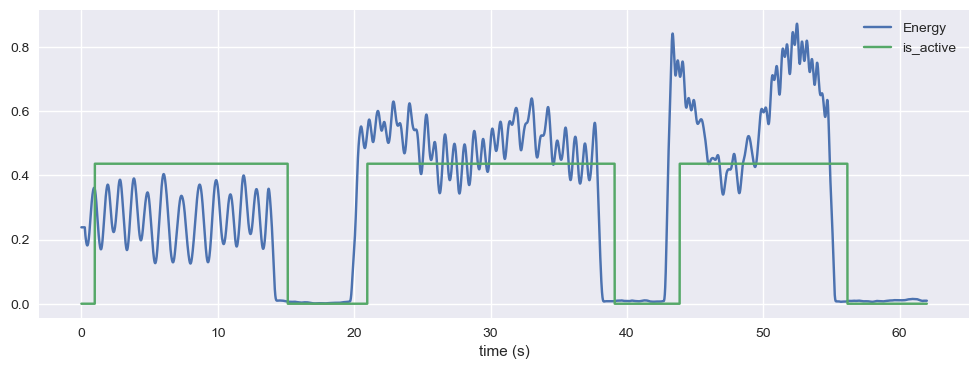

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df["time_s"], df["Energy"], label="Energy")
plt.plot(df["time_s"], df["is_active"] * df["Energy"].max()*0.5, label="is_active")
plt.legend()
plt.xlabel("time (s)")
plt.show()

---

## 接下来可以做什么？

有了 `is_active`：

1. 把连续 `is_active==1` 的区间提取出来 → 就是一个个 **active segment**。
2. 对每个 active segment 再做 **Layer 2 的 rep segmentation（峰值检测）**。

如果你愿意，下一步我可以直接给你一段：

> “根据 `is_active` 自动提取所有 active segment，并对其中一个动作（例如 push-up）做峰值分割”的代码模板。

## 通用工具函数
- `moving_average`：平滑能量/掩码
- `mask_to_segments`：将布尔掩码转为 (起始索引, 结束索引) 列表，并过滤过短片段。

In [35]:
def moving_average(arr: np.ndarray, window: float) -> np.ndarray:
    window = max(1, int(window))
    kernel = np.ones(window) / float(window)
    return np.convolve(arr, kernel, mode='same')

def mask_to_segments(mask: np.ndarray, fs_hz: float, min_duration: float = 0.5, merge_gap: float = 0.3):
    segments = []
    start = None
    for idx, flag in enumerate(mask):
        if flag and start is None:
            start = idx
        elif not flag and start is not None:
            segments.append((start, idx))
            start = None
    if start is not None:
        segments.append((start, len(mask)))

    filtered = []
    for seg_start, seg_end in segments:
        duration = (seg_end - seg_start) / fs_hz
        if duration < min_duration:
            continue
        if filtered and (seg_start - filtered[-1][1]) / fs_hz <= merge_gap:
            prev_start, _ = filtered[-1]
            filtered[-1] = (prev_start, seg_end)
        else:
            filtered.append((seg_start, seg_end))
    return filtered


## 方法一：基于信号能量的阈值切分
- 对加速度、角速度的模长做零均值化，再计算滑动窗口能量。
- 采用鲁棒阈值（中位数 + `std_scale` × 标准差）生成活动掩码，并做平滑与合并。

In [36]:
def energy_segmentation(
    df: pd.DataFrame,
    fs_hz: float = FS_HZ,
    window_sec: float = 0.25,
    smooth_sec: float = 0.15,
    std_scale: float = 1.3,
    accel_weight: float = 1.0,
    gyro_weight: float = 0.5,
):
    acc_dyn = df['acc_mag'].to_numpy() - df['acc_mag'].mean()
    gyro_dyn = df['gyro_mag'].to_numpy() - df['gyro_mag'].mean()
    window = window_sec * fs_hz
    energy = accel_weight * moving_average(acc_dyn**2, window) + gyro_weight * moving_average(gyro_dyn**2, window)
    baseline = np.median(energy)
    threshold = baseline + std_scale * np.std(energy)
    raw_mask = energy > threshold
    smooth_window = max(1, int(smooth_sec * fs_hz))
    smooth_mask = (
        pd.Series(raw_mask)
        .rolling(window=smooth_window, center=True, min_periods=1)
        .mean()
        > 0.5
    ).to_numpy()
    segments = mask_to_segments(smooth_mask, fs_hz=fs_hz)
    return segments, energy, threshold, smooth_mask


NameError: name 'FS_HZ' is not defined

## 方法二：无监督学习（KMeans）切分
- 滑窗抽取统计与能量特征（均值、标准差、峰-峰值、能量）。
- 使用 2 类 KMeans，将能量更高的一类视为“动作”，还原到时间轴形成掩码。

In [191]:
def kmeans_segmentation(
    df: pd.DataFrame,
    fs_hz: float = FS_HZ,
    window_sec: float = 0.8,
    step_sec: float = 0.2,
):
    acc = df['acc_mag'].to_numpy()
    gyro = df['gyro_mag'].to_numpy()
    window = max(1, int(window_sec * fs_hz))
    step = max(1, int(step_sec * fs_hz))
    spans: list[tuple[int, int]] = []
    features = []
    for start in range(0, len(df), step):
        end = min(start + window, len(df))
        if end - start < 5:
            continue
        acc_slice = acc[start:end]
        gyro_slice = gyro[start:end]
        acc_energy = float(np.mean((acc_slice - acc_slice.mean()) ** 2))
        gyro_energy = float(np.mean((gyro_slice - gyro_slice.mean()) ** 2))
        features.append([
            acc_slice.mean(),
            acc_slice.std(),
            acc_slice.max() - acc_slice.min(),
            gyro_slice.mean(),
            gyro_slice.std(),
            gyro_slice.max() - gyro_slice.min(),
            acc_energy,
            gyro_energy,
        ])
        spans.append((start, end))

    if not features:
        raise RuntimeError('窗口特征为空，请检查数据长度或窗口大小。')

    features = np.asarray(features)
    model = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = model.fit_predict(features)
    energy_per_cluster = []
    energy_feature = features[:, 6] + features[:, 7]
    for cluster_id in range(2):
        mask = labels == cluster_id
        if not np.any(mask):
            energy_per_cluster.append(-np.inf)
        else:
            energy_per_cluster.append(float(energy_feature[mask].mean()))
    active_label = int(np.argmax(energy_per_cluster))

    coverage = np.zeros(len(df))
    active_score = np.zeros(len(df))
    for (start, end), label in zip(spans, labels):
        coverage[start:end] += 1
        if label == active_label:
            active_score[start:end] += 1
    activity_mask = active_score >= coverage / 2
    segments = mask_to_segments(activity_mask, fs_hz=fs_hz)
    return segments, spans, labels, activity_mask


## 运行两种切分方法并查看片段信息

In [192]:
energy_segments, energy_trace, energy_threshold, energy_mask = energy_segmentation(df, fs_hz=FS_HZ)
kmeans_segments, kmeans_spans, kmeans_labels, kmeans_mask = kmeans_segmentation(df, fs_hz=FS_HZ)

def describe_segments(name: str, segments: list[tuple[int, int]]):
    print(f'{name}: 共 {len(segments)} 段')
    for idx, (start, end) in enumerate(segments, 1):
        duration = (end - start) / FS_HZ
        print(f'  {idx:02d}: {start/FS_HZ:.2f}s -> {end/FS_HZ:.2f}s (持续 {duration:.2f}s)')

describe_segments('能量阈值', energy_segments)
describe_segments('KMeans', kmeans_segments)


能量阈值: 共 1 段
  01: 16.48s -> 19.42s (持续 2.94s)
KMeans: 共 3 段
  01: 0.00s -> 14.42s (持续 14.42s)
  02: 19.64s -> 38.27s (持续 18.62s)
  03: 42.53s -> 55.38s (持续 12.86s)


## 可视化两种切分结果
- 上图叠加加速度/角速度模长与切分片段。
- 下图展示对应的能量轨迹或聚类掩码。

/var/folders/m8/xb_qq70937vgfshqzhs2jjpr0000gn/T/ipykernel_51232/228443738.py:20: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/m8/xb_qq70937vgfshqzhs2jjpr0000gn/T/ipykernel_51232/228443738.py:20: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/m8/xb_qq70937vgfshqzhs2jjpr0000gn/T/ipykernel_51232/228443738.py:20: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/m8/xb_qq70937vgfshqzhs2jjpr0000gn/T/ipykernel_51232/228443738.py:20: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/m8/xb_qq70937vgfshqzhs2jjpr0000gn/T/ipykernel_51232/228443738.py:20: UserWarning: Glyph 20999 (\N{CJK UNIFIED IDEOGRAPH-5207}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/m8/xb_qq70937vgfshqzhs2jjpr0000gn/T/ipyker

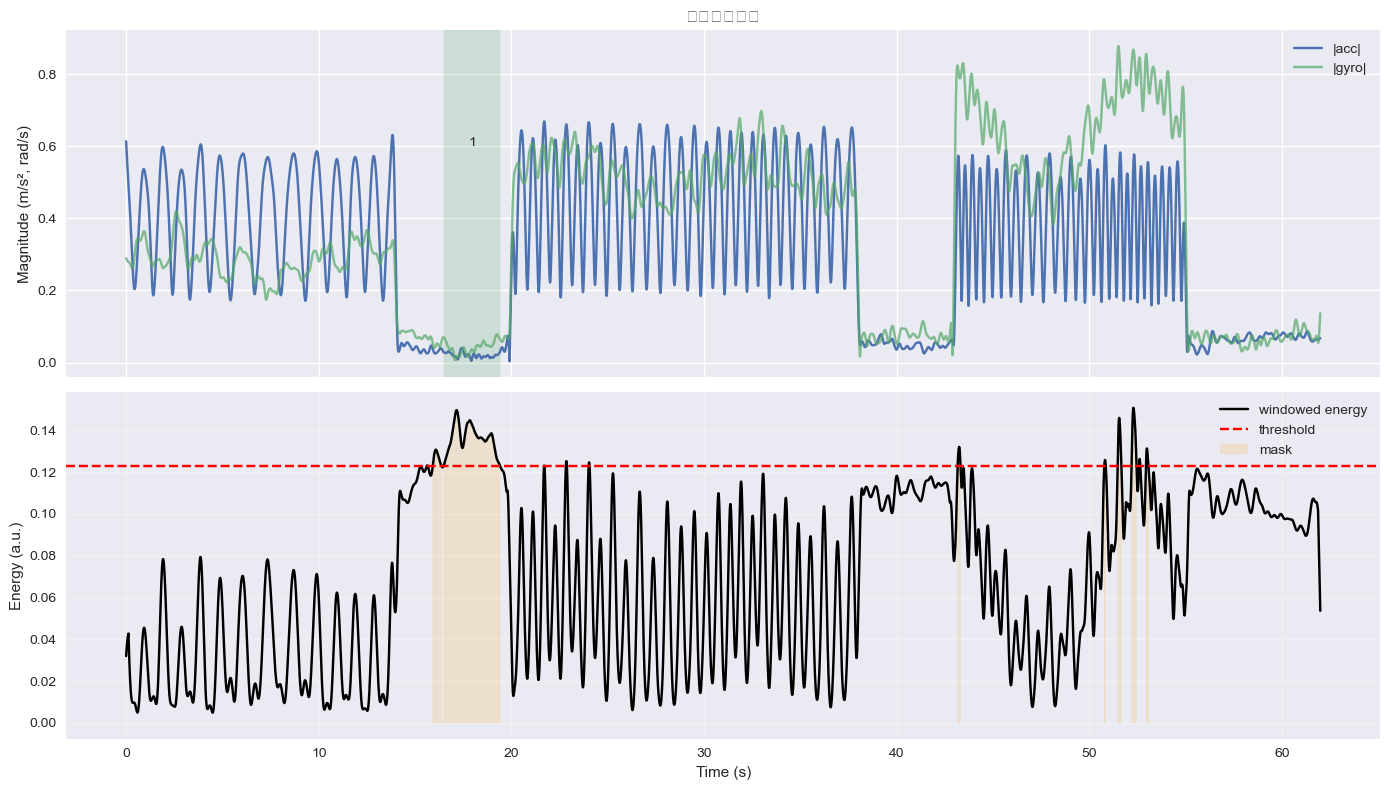

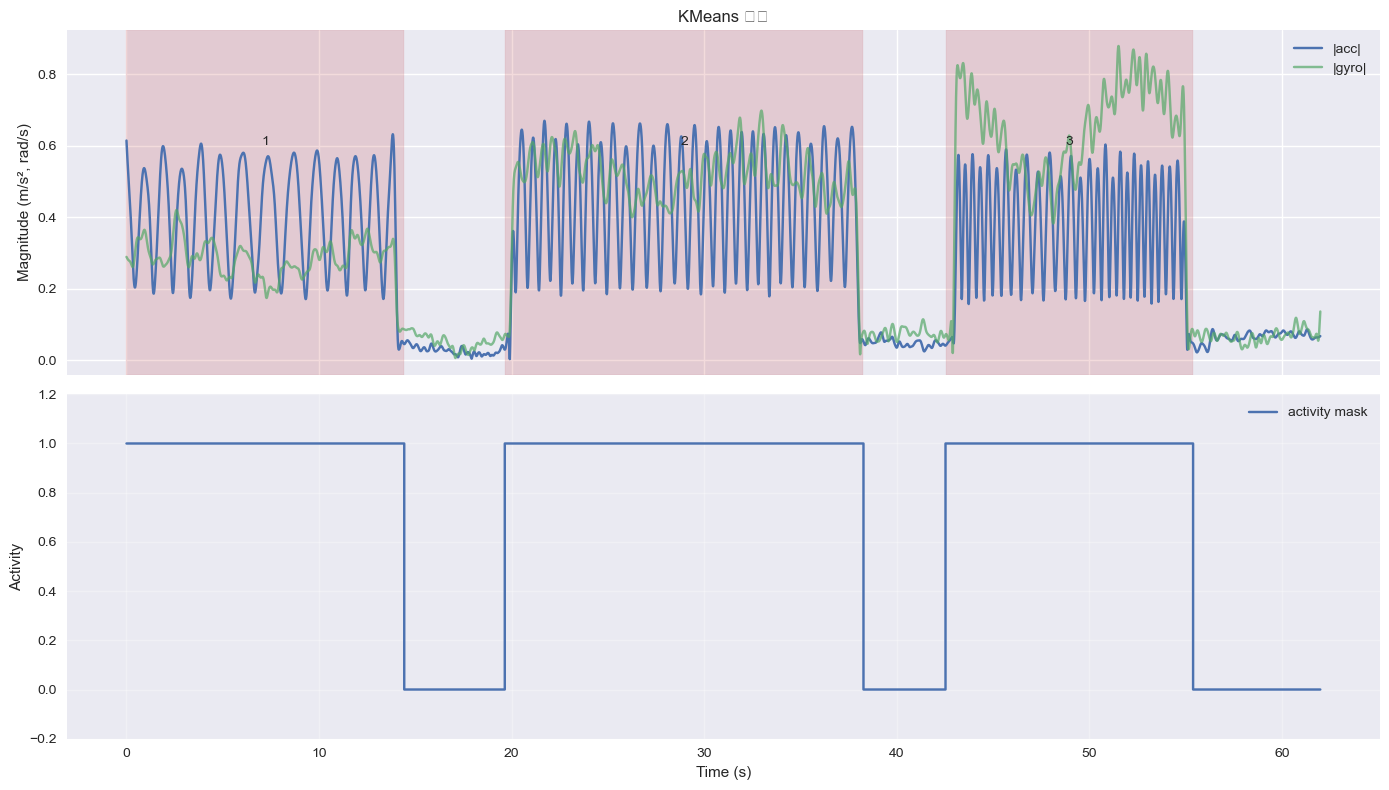

In [193]:
def plot_energy_view(df: pd.DataFrame, segments: list[tuple[int, int]], energy: np.ndarray, threshold: float, mask: np.ndarray):
    time_s = df['time_s'].to_numpy()
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    axes[0].plot(time_s, df['acc_mag'], label='|acc|')
    axes[0].plot(time_s, df['gyro_mag'], label='|gyro|', alpha=0.7)
    for idx, (start, end) in enumerate(segments, 1):
        axes[0].axvspan(time_s[start], time_s[end - 1], color='C1', alpha=0.2)
        axes[0].text((time_s[start] + time_s[end - 1]) / 2, df['acc_mag'].max() * 0.9, str(idx), ha='center')
    axes[0].set_ylabel('Magnitude (m/s², rad/s)')
    axes[0].legend(loc='upper right')
    axes[0].set_title('能量阈值切分')

    axes[1].plot(time_s, energy, color='black', label='windowed energy')
    axes[1].axhline(threshold, color='red', linestyle='--', label='threshold')
    axes[1].fill_between(time_s, 0, energy, where=mask, color='orange', alpha=0.15, label='mask')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Energy (a.u.)')
    axes[1].legend(loc='upper right')
    axes[1].grid(alpha=0.3)
    plt.tight_layout()


def plot_kmeans_view(df: pd.DataFrame, segments: list[tuple[int, int]], activity_mask: np.ndarray):
    time_s = df['time_s'].to_numpy()
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    axes[0].plot(time_s, df['acc_mag'], label='|acc|')
    axes[0].plot(time_s, df['gyro_mag'], label='|gyro|', alpha=0.7)
    for idx, (start, end) in enumerate(segments, 1):
        axes[0].axvspan(time_s[start], time_s[end - 1], color='C2', alpha=0.2)
        axes[0].text((time_s[start] + time_s[end - 1]) / 2, df['acc_mag'].max() * 0.9, str(idx), ha='center')
    axes[0].set_ylabel('Magnitude (m/s², rad/s)')
    axes[0].legend(loc='upper right')
    axes[0].set_title('KMeans 切分')

    axes[1].step(time_s, activity_mask.astype(int), where='post', label='activity mask')
    axes[1].set_ylim(-0.2, 1.2)
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Activity')
    axes[1].grid(alpha=0.3)
    axes[1].legend(loc='upper right')
    plt.tight_layout()


plot_energy_view(df, energy_segments, energy_trace, energy_threshold, energy_mask)
plot_kmeans_view(df, kmeans_segments, kmeans_mask)


## 导出片段到 `data/segmented/<exercise>/`
"
        "为避免不同方法互相覆盖，文件名包含源文件名与切分方法（`_energy_segXX` / `_kmeans_segXX`）。

In [194]:
def export_segments(df: pd.DataFrame, segments: list[tuple[int, int]], base_name: str, method: str):
    exported = []
    for idx, (start, end) in enumerate(segments, 1):
        segment_df = df.iloc[start:end].copy()
        out_path = output_dir / f'{base_name}_{method}_seg{idx:02d}.csv'
        segment_df.to_csv(out_path, index=False)
        exported.append(out_path)
    return exported

base_name = Path(input_path).stem
energy_exports = export_segments(df, energy_segments, base_name, 'energy')
kmeans_exports = export_segments(df, kmeans_segments, base_name, 'kmeans')

print(f'能量阈值法已写入 {len(energy_exports)} 段')
for path in energy_exports:
    print(f'  - {path}')
print(f'KMeans 已写入 {len(kmeans_exports)} 段')
for path in kmeans_exports:
    print(f'  - {path}')


能量阈值法已写入 1 段
  - /Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/segmented/deep-squat/athlete_02_deep-squat_2025-11-22T17-45-00_19_energy_seg01.csv
KMeans 已写入 3 段
  - /Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/segmented/deep-squat/athlete_02_deep-squat_2025-11-22T17-45-00_19_kmeans_seg01.csv
  - /Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/segmented/deep-squat/athlete_02_deep-squat_2025-11-22T17-45-00_19_kmeans_seg02.csv
  - /Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/segmented/deep-squat/athlete_02_deep-squat_2025-11-22T17-45-00_19_kmeans_seg03.csv
